# Question 15

***Apply HDBSCAN on UMAP-transformed 20-category data.***



In [1]:
# Can be deleted when compile into main file
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import umap
# from plotmat import plot_mat 
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# load data
newsgroups = fetch_20newsgroups(remove=('headers', 'footers'))

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

In [2]:
import hdbscan
from sklearn.metrics import cluster
from joblib import Memory
from tempfile import mkdtemp

# Make code run much faster
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=False)

v_measure_score = []


def HDBSCAN_cluster_size_plot(tfidf, target, metric):
    
    n_components = [5, 20, 200]
    min_cluster_size = [20, 100, 200]
    
    for n in n_components:
        for m in min_cluster_size:
            umap_cosine = umap.UMAP(n_components=n, metric=metric, random_state=0)
            umap_trunc = umap_cosine.fit_transform(tfidf)
            
            clusterers = hdbscan.HDBSCAN(min_cluster_size=m, gen_min_span_tree=True, memory=memory)
            cluster_data = clusterers.fit_predict(umap_trunc)
            
            x = cluster.v_measure_score(target, cluster_data)
            print("Results for n_components = ", n, "min_cluster_size = ", m, ":")
            print("Homogeneity: ", cluster.homogeneity_score(target, cluster_data))
            print("Completeness: ", cluster. completeness_score(target, cluster_data))
            print("V-measure: ", x)
            print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(target, cluster_data))
            print("Silhouette Coefficient: ", cluster.silhouette_score(tfidf, cluster_data, sample_size=2000), "\n")
            
            # V-measure: harmonic mean of homogeneity and completeness:
            v_measure_score.append(x)
            
    max_score = max(v_measure_score)
    index = v_measure_score.index(max_score)
    
    n_ = (index + 1)//3 -1
    m_ = index%3
    print("The best choice for n_components is ", n_components[n_])
    print("And min_cluster_size = ", min_cluster_size[m_],)
                 

In [3]:
HDBSCAN_cluster_size_plot(newsgroups_tfidf, newsgroups.target, 'cosine')

Results for n_components =  5 min_cluster_size =  20 :
Homogeneity:  0.4521477464078121
Completeness:  0.4886371704434999
V-measure:  0.46968481630543973
Adjusted Rand-Index:  0.13264413050529356
Silhouette Coefficient:  -0.2731478789323629 

Results for n_components =  5 min_cluster_size =  100 :
Homogeneity:  0.37956705407253966
Completeness:  0.6083371767339277
V-measure:  0.4674638347630229
Adjusted Rand-Index:  0.17240402176598615
Silhouette Coefficient:  -0.0026634783647324005 

Results for n_components =  5 min_cluster_size =  200 :
Homogeneity:  0.3294836727864104
Completeness:  0.619259017263123
V-measure:  0.43011817124684093
Adjusted Rand-Index:  0.13341680695389907
Silhouette Coefficient:  0.0021583543232462717 

Results for n_components =  20 min_cluster_size =  20 :
Homogeneity:  0.4306669716953792
Completeness:  0.47094231255045566
V-measure:  0.4499050822418602
Adjusted Rand-Index:  0.09835500957623937
Silhouette Coefficient:  -0.2713243989126679 

Results for n_compone

In [4]:
HDBSCAN_cluster_size_plot(newsgroups_tfidf, newsgroups.target, 'euclidean')

Results for n_components =  5 min_cluster_size =  20 :
Homogeneity:  0.012908451224089339
Completeness:  0.03477685316489564
V-measure:  0.01882824566430026
Adjusted Rand-Index:  0.004097615020469038
Silhouette Coefficient:  -0.02180422010929721 

Results for n_components =  5 min_cluster_size =  100 :
Homogeneity:  0.005300750261072723
Completeness:  0.014508833892166104
V-measure:  0.0077646965677657595
Adjusted Rand-Index:  0.0028342485188443288
Silhouette Coefficient:  -0.0004756989504402169 

Results for n_components =  5 min_cluster_size =  200 :
Homogeneity:  0.003156315851113698
Completeness:  0.007547217416869919
V-measure:  0.004451128682137593
Adjusted Rand-Index:  0.0012692313744692724
Silhouette Coefficient:  -0.0006019019067839042 

Results for n_components =  20 min_cluster_size =  20 :
Homogeneity:  0.010581118889877342
Completeness:  0.06835318128737003
V-measure:  0.01832544625286936
Adjusted Rand-Index:  0.0005403910532602968
Silhouette Coefficient:  -0.0315939051428

***Modifying other parameters in HDBSCAN to get better performance.***

min_samples = the minimum number of neighbours to a core point. The higher this is, the more points are going to be discarded as noise/outliers. This is from DBScan part of HDBScan.

min_cluster_size = the minimum size a final cluster can be. The higher this is, the bigger your clusters will be. This is from the H part of HDBScan.

Increasing min_samples will increase the size of the clusters, but it does so by discarding data as outliers using DBSCAN.

Increasing min_cluster_size while keeping min_samples small, by comparison, keeps those outliers but instead merges any smaller clusters with their most similar neighbour until all clusters are above min_cluster_size.

So:

If you want many highly specific clusters, use a small min_samples and a small min_cluster_size.

If you want more generalized clusters but still want to keep most detail, use a small min_samples and a large min_cluster_size

If you want very very general clusters and to discard a lot of noise in the clusters, use a large min_samples and a large min_cluster_size.

In [5]:
umap_cosine = umap.UMAP(n_components=5, metric='cosine', random_state=0)
umap_trunc = umap_cosine.fit_transform(newsgroups_tfidf)

***Modify min_samples***

In [6]:
#Change min_samples:
min_samples = [None, 5, 20, 100, 200]
v_measure_score = []

for i in min_samples:
    clusterers = hdbscan.HDBSCAN(algorithm='best', cluster_selection_epsilon = 0, alpha=1.0, approx_min_span_tree=True,gen_min_span_tree=True, 
                           leaf_size=40, memory=memory,metric='euclidean', min_cluster_size=200, 
                           min_samples=i, p=None)

    cluster_data = clusterers.fit_predict(umap_trunc)
    
    x = cluster.v_measure_score(newsgroups.target, cluster_data)
    
    print("When min_samples = ", i)
    print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, cluster_data))
    print("Completeness: ", cluster. completeness_score(newsgroups.target, cluster_data))
    print("V-measure: ", x)
    print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, cluster_data))
    print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, cluster_data, sample_size=2000), "\n")
    
    v_measure_score.append(x)
            
max_score = max(v_measure_score)
index = v_measure_score.index(max_score)

print("The best choice for min_samples is ", min_samples[index])

When min_samples =  None
Homogeneity:  0.3294836727864104
Completeness:  0.619259017263123
V-measure:  0.43011817124684093
Adjusted Rand-Index:  0.13341680695389907
Silhouette Coefficient:  0.0029968717611345377 

When min_samples =  5
Homogeneity:  0.3837941643852793
Completeness:  0.624656865570427
V-measure:  0.4754611827996442
Adjusted Rand-Index:  0.1668050497165791
Silhouette Coefficient:  0.0007323535325348909 

When min_samples =  20
Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  0.001214926634620734 

When min_samples =  100
Homogeneity:  0.36883427624402537
Completeness:  0.6067784142036216
V-measure:  0.45879000844198164
Adjusted Rand-Index:  0.1688191244415909
Silhouette Coefficient:  0.0028988622173680995 

When min_samples =  200
Homogeneity:  0.3294836727864104
Completeness:  0.619259017263123
V-measure:  0.43011817124684093
Adjusted Rand-Index:  0.13341680

***Modify cluster_selection_epsilon***

cluster_selection_epsilon ensures that clusters below the given threshold are not split up any further.

In [7]:
#Change cluster_selection_epsilon:
cluster_selection_epsilon = [0, 0.5, 1]
v_measure_score = []

for i in cluster_selection_epsilon:
    clusterers = hdbscan.HDBSCAN(algorithm='best', cluster_selection_epsilon = i, alpha=1.0, approx_min_span_tree=True,gen_min_span_tree=True, 
                           leaf_size=40, memory=memory,metric='euclidean', min_cluster_size=200, 
                           min_samples= 20, p=None)

    cluster_data = clusterers.fit_predict(umap_trunc)
    
    x = cluster.v_measure_score(newsgroups.target, cluster_data)

    print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, cluster_data))
    print("Completeness: ", cluster. completeness_score(newsgroups.target, cluster_data))
    print("V-measure: ", x)
    print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, cluster_data))
    print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, cluster_data, sample_size=2000), "\n")
    
    v_measure_score.append(x)
            
max_score = max(v_measure_score)
index = v_measure_score.index(max_score)

print("The best choice for min_samples is ", cluster_selection_epsilon[index])

Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  0.0025822458091369644 

Homogeneity:  0.358662425309811
Completeness:  0.6225976034644808
V-measure:  0.45513392964671634
Adjusted Rand-Index:  0.17137483277182522
Silhouette Coefficient:  0.0019049519845652381 

Homogeneity:  0.05099311893908215
Completeness:  0.33293748112164917
V-measure:  0.08844057010006037
Adjusted Rand-Index:  0.009483961984033078
Silhouette Coefficient:  -0.005025261384888374 

The best choice for min_samples is  0


***Modify Alpha***

***Alpha should not be adjusted unless min_samples or cluster_selection_epsilon is not providing your desired result. Adjusting alpha will result in recomputing the hard comptuation of the single linkage tree. But for this project, in order to observe how Alpha value affects the scores, we are going to pick 4 floats Alpha = 0.5, 0.75, 1.0, 1.3 to check the change of results***

In [8]:
#Change alpha:
alpha = [0.5, 0.75, 1.0, 1.3]
v_measure_score = []

for i in alpha:
    clusterers = hdbscan.HDBSCAN(algorithm='best', cluster_selection_epsilon = 0, alpha= i, approx_min_span_tree=True,gen_min_span_tree=True, 
                           leaf_size=40, memory=memory,metric='euclidean', min_cluster_size=200, 
                           min_samples= 20, p=None)

    cluster_data = clusterers.fit_predict(umap_trunc)
    
    x = cluster.v_measure_score(newsgroups.target, cluster_data)

    print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, cluster_data))
    print("Completeness: ", cluster. completeness_score(newsgroups.target, cluster_data))
    print("V-measure: ", x)
    print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, cluster_data))
    print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, cluster_data, sample_size=2000), "\n")
    
    v_measure_score.append(x)
            
max_score = max(v_measure_score)
index = v_measure_score.index(max_score)

print("The best choice for alpha is ", alpha[index])

Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  -0.00045402171581416254 

Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  0.0014153513039527263 

Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  -7.227213296008664e-05 

Homogeneity:  0.37556550760247165
Completeness:  0.62547498490387
V-measure:  0.4693253309062962
Adjusted Rand-Index:  0.1729153286652142
Silhouette Coefficient:  0.00270879892394077 

The best choice for alpha is  0.5


# Question 16

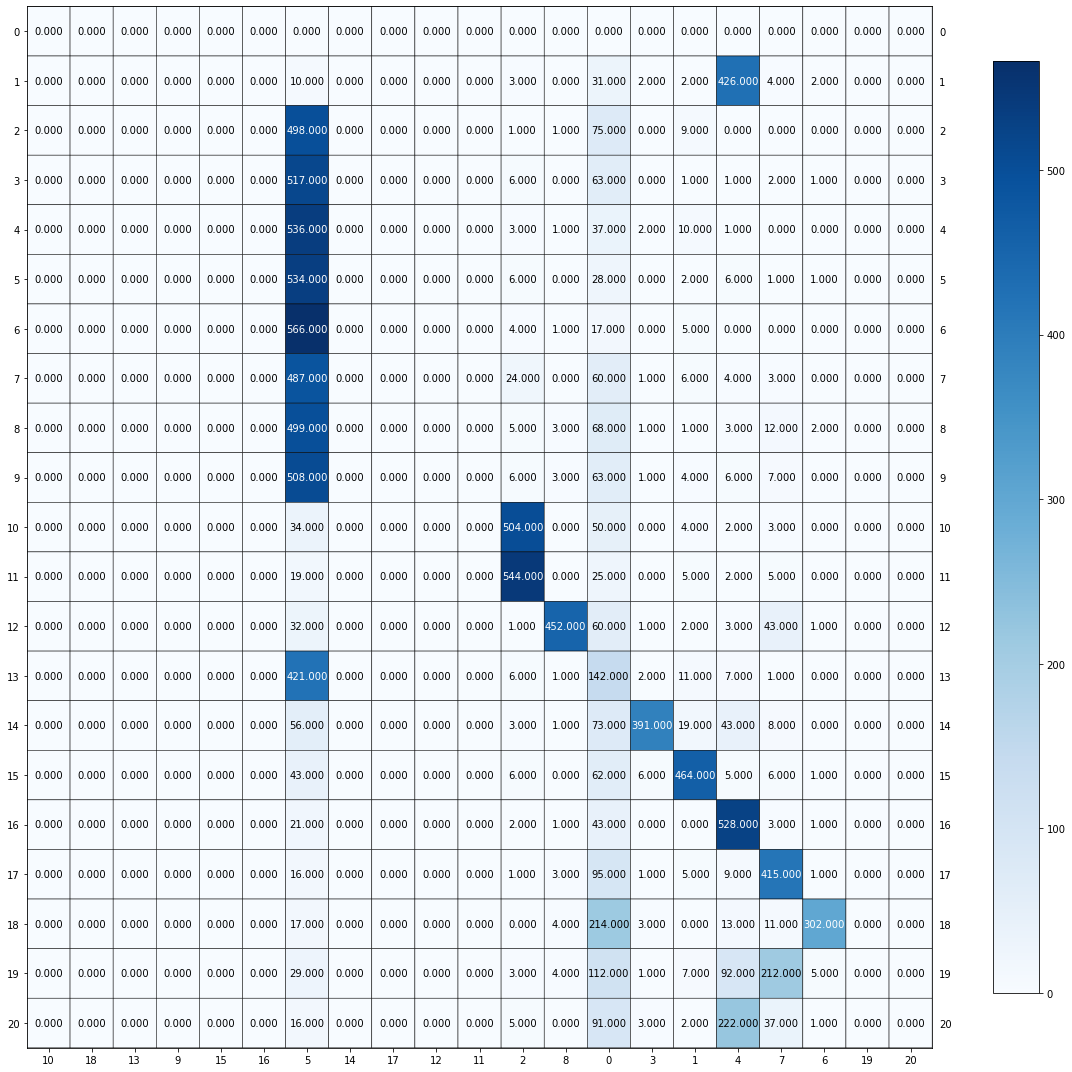

In [9]:
from plotmat import plot_mat 

clusterers = hdbscan.HDBSCAN(algorithm='best', cluster_selection_epsilon = 0, alpha= 1.0, approx_min_span_tree=True,
                             gen_min_span_tree=True, leaf_size=40, memory=memory,metric='euclidean', min_cluster_size=200, 
                             min_samples= 20, p=None)

cluster_data = clusterers.fit_predict(umap_trunc)

cm = confusion_matrix(newsgroups.target, cluster_data)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

***How many clusters are given by the model? What does “-1” mean for the clustering labels? Interpret the contingency matrix considering the answer to these questions.***

From the graph we can find 9 clusters.If we find -1 for the clustering label, it indicates outlier or noise sample that are not classified into the table. That is one of the pros of using HDBSCAN that it can tell outliers, which Kmeans cannot do.

# Question 17

In [12]:
from sklearn.cluster import AgglomerativeClustering

dictionary = {}

def Score_(reducer, clustering_method, newsgroups_tfidf):
    array = [5, 20, 200]
    for i in array:
        if reducer == "SVD":
            svd = TruncatedSVD(n_components = i, random_state=0)
            data = svd.fit_transform(newsgroups_tfidf)
        elif reducer == "NMF":
            nmf = NMF(n_components= i, init='random', random_state=0, max_iter=300)
            data = nmf.fit_transform(newsgroups_tfidf)
        elif reducer == "UMAP":
            umap_cosine = umap.UMAP(n_components= i, metric='cosine', random_state=0)
            data = umap_cosine.fit_transform(newsgroups_tfidf)
        else:
            data = newsgroups_tfidf
        
        if clustering_method == 'KMeans':
            All_score = []
            hs, cs, vs, ars, ss = [],[],[],[],[]
            
            for i in [10, 20, 50]:
                kmeans = KMeans(random_state=0, n_clusters=i, max_iter=1000, n_init=30)
                kmeans.fit(data)
                
                hs.append(cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
                cs.append(cluster. completeness_score(newsgroups.target, kmeans.labels_))
                vs.append(cluster.v_measure_score(newsgroups.target, kmeans.labels_))
                ars.append(cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
                ss.append(cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))
                
            All_score.append(hs)
            All_score.append(cs)
            All_score.append(vs)
            All_score.append(ars)
            All_score.append(ss)

            # In case you need all data
            String = reducer + "_" + 'KMeans'
            dictionary[String] = All_score
                
            
                
        elif clustering_method == 'Agglomerative':
            All_score = []
            hs, cs, vs, ars, ss = [],[],[],[],[]
            
            Agglomerative = AgglomerativeClustering(n_clusters=20, linkage='ward')
            Agglomerative.fit(data)
            
            hs.append(cluster.homogeneity_score(newsgroups.target, Agglomerative.labels_))
            cs.append(cluster. completeness_score(newsgroups.target, Agglomerative.labels_))
            vs.append(cluster.v_measure_score(newsgroups.target, Agglomerative.labels_))
            ars.append(cluster.adjusted_rand_score(newsgroups.target, Agglomerative.labels_))
            ss.append(cluster.silhouette_score(newsgroups_tfidf, Agglomerative.labels_, sample_size=2000))

            All_score.append(hs)
            All_score.append(cs)
            All_score.append(vs)
            All_score.append(ars)
            All_score.append(ss)

            String = reducer + "_" + 'Agglomerative'
            dictionary[String] = All_score
            
           
            
        else:
            All_score = []
            hs, cs, vs, ars, ss = [],[],[],[],[]
            
            for i in [100, 200]:
                clusterers = hdbscan.HDBSCAN(algorithm='best', cluster_selection_epsilon = 0, alpha= 1.0,
                                             approx_min_span_tree=True, gen_min_span_tree=True, leaf_size=40, 
                                             memory=memory,metric='euclidean', min_cluster_size=i, 
                                             min_samples= 20, p=None)
                cluster_data = clusterers.fit_predict(data)

                hs.append(cluster.homogeneity_score(newsgroups.target, cluster_data))
                cs.append(cluster. completeness_score(newsgroups.target, cluster_data))
                vs.append(cluster.v_measure_score(newsgroups.target, cluster_data))
                ars.append(cluster.adjusted_rand_score(newsgroups.target, cluster_data))
                ss.append(cluster.silhouette_score(newsgroups_tfidf, cluster_data, sample_size=2000))
                
            All_score.append(hs)
            All_score.append(cs)
            All_score.append(vs)
            All_score.append(ars)
            All_score.append(ss)

            String = reducer + "_" + 'HDBSCAN'
            dictionary[String] = All_score

    max_score = max(vs)
    print("Best v_measure_score for ", reducer, " by",clustering_method ," = ", max_score)

In [ ]:
Score_('None', 'KMeans', newsgroups_tfidf)
Score_('SVD', 'KMeans', newsgroups_tfidf)
Score_('NMF', 'KMeans', newsgroups_tfidf)
Score_('UMAP', 'KMeans', newsgroups_tfidf)

In [ ]:
Score_('None', 'Agglomerative', newsgroups_tfidf)
Score_('SVD', 'Agglomerative', newsgroups_tfidf)
Score_('NMF', 'Agglomerative', newsgroups_tfidf)
Score_('UMAP', 'Agglomerative', newsgroups_tfidf)

In [ ]:
Score_('None', 'HDBSCAN', newsgroups_tfidf)
Score_('SVD', 'HDBSCAN', newsgroups_tfidf)
Score_('NMF', 'HDBSCAN', newsgroups_tfidf)
Score_('UMAP', 'HDBSCAN', newsgroups_tfidf)

# Question 18